<a href="https://colab.research.google.com/github/raj-gupta1/Tomato-leaves-disease-Predictor/blob/main/Tomato_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/tomato-disease-prediction/Tomato_disease.zip" -d "/content/drive/MyDrive/tomato-disease-prediction/unzipped_data"

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
path = "/content/drive/MyDrive/tomato-disease-prediction";
train_path = os.path.join(path, "/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/train")
print(os.listdir(train_path))
print("*"*100)
valid_path = os.path.join(path, "/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/valid")
print(os.listdir(valid_path))

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
****************************************************************************************************
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
from glob import glob
folders = glob("/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/train/*")
len(folders)

10

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_size

(224, 224)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2, 
  subset="training",
  seed=123,
  image_size=(img_height, img_width),batch_size=batch_size)

Found 18345 files belonging to 10 classes.
Using 14676 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4585 files belonging to 10 classes.
Using 917 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names )

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


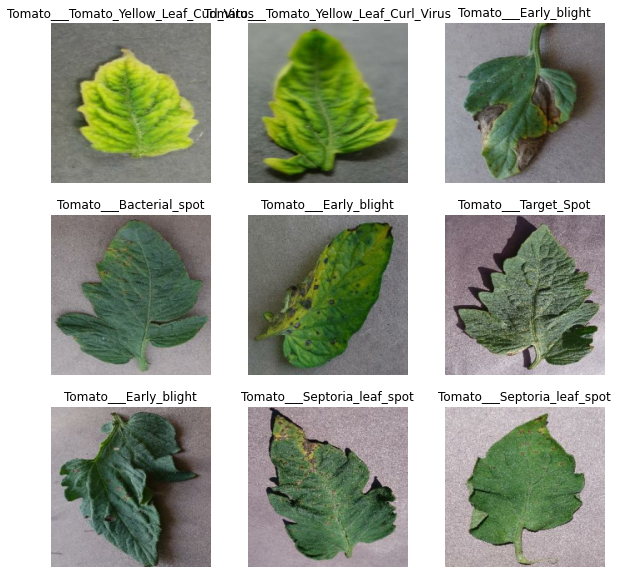

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.8121078


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**<h1> Model 1 (InceptionV3)</h1>**

In [ ]:
IMAGE_SIZE = [224,224]
IMAGE_SIZE

[224, 224]

In [ ]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/train/*')

In [ ]:
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)
model_INCEPTION_V3 = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model_INCEPTION_V3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model_INCEPTION_V3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [ ]:
valid_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


In [ ]:
#model_INCEPTION_V3.fit(training_set,
                       validation_data=valid_set,
                       validation_batch_size=64,
                       epochs=10)

Epoch 1/10
574/574 [==============================] - 161s 220ms/step - loss: 2.7272 - accuracy: 0.7042 - val_loss: 3.7590 - val_accuracy: 0.6971
Epoch 2/10
574/574 [==============================] - 126s 220ms/step - loss: 1.2159 - accuracy: 0.8534 - val_loss: 1.9023 - val_accuracy: 0.8190
Epoch 3/10
574/574 [==============================] - 123s 214ms/step - loss: 0.8440 - accuracy: 0.8994 - val_loss: 2.2852 - val_accuracy: 0.8159
Epoch 4/10
574/574 [==============================] - 123s 213ms/step - loss: 0.5751 - accuracy: 0.9282 - val_loss: 2.1715 - val_accuracy: 0.8279
Epoch 5/10
574/574 [==============================] - 123s 214ms/step - loss: 0.6322 - accuracy: 0.9320 - val_loss: 2.0761 - val_accuracy: 0.8497
Epoch 6/10
574/574 [==============================] - 124s 216ms/step - loss: 0.6079 - accuracy: 0.9354 - val_loss: 2.5943 - val_accuracy: 0.8421
Epoch 7/10
574/574 [==============================] - 125s 218ms/step - loss: 0.5060 - accuracy: 0.9473 - val_loss: 2.6155 -

In [ ]:
model_INCEPTION_V3.save('/content/drive/MyDrive/tomato-disease-prediction/model_INCEPTION_V3_best.h5')

In [ ]:
score_train = model_INCEPTION_V3.evaluate(training_set, verbose=2)
accuracy_train = 100*score_train[1]

print('Train accuracy = %.4f%% ' % accuracy_train) 

574/574 - 95s - loss: 0.6120 - accuracy: 0.9460
Train accuracy = 94.5980% 


In [ ]:
score_val = model_INCEPTION_V3.evaluate(valid_set, verbose=2)
accuracy_val = 100*score_val[1]

print('Validate accuracy = %.4f%% ' % accuracy_val)

144/144 - 24s - loss: 4.1287 - accuracy: 0.8198
Validate accuracy = 81.9847% 


for InceptionV3
574/574 - 95s - loss: 0.6120 - accuracy: 0.9460
Train accuracy = 94.5980% 
144/144 - 24s - loss: 4.1287 - accuracy: 0.8198
Validate accuracy = 81.9847%

**<h1>Model 2 (VGG19)</h1>**

In [ ]:
IMAGE_SIZE = [224,224]
IMAGE_SIZE

[224, 224]

In [ ]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/train/*')

In [ ]:
x = Flatten()(vgg19.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

model_VGG19 = Model(inputs=vgg19.input, outputs=prediction)

In [ ]:
model_VGG19.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model_VGG19.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 18345 images belonging to 10 classes.


In [ ]:
valid_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New Plant Diseases Dataset(Augmented)/valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4585 images belonging to 10 classes.


In [ ]:
#model_VGG19.fit(training_set,validation_data=valid_set,validation_batch_size=64,epochs=10)

Epoch 1/10
574/574 [==============================] - 223s 369ms/step - loss: 0.7131 - accuracy: 0.7640 - val_loss: 0.5106 - val_accuracy: 0.8264
Epoch 2/10
574/574 [==============================] - 209s 364ms/step - loss: 0.2887 - accuracy: 0.8988 - val_loss: 0.3923 - val_accuracy: 0.8622
Epoch 3/10
574/574 [==============================] - 208s 363ms/step - loss: 0.1880 - accuracy: 0.9362 - val_loss: 0.4037 - val_accuracy: 0.8667
Epoch 4/10
574/574 [==============================] - 210s 366ms/step - loss: 0.1414 - accuracy: 0.9518 - val_loss: 0.3388 - val_accuracy: 0.8929
Epoch 5/10
574/574 [==============================] - 208s 362ms/step - loss: 0.0833 - accuracy: 0.9735 - val_loss: 0.3646 - val_accuracy: 0.8803
Epoch 6/10
574/574 [==============================] - 208s 361ms/step - loss: 0.0908 - accuracy: 0.9682 - val_loss: 0.5582 - val_accuracy: 0.8462
Epoch 7/10
574/574 [==============================] - 208s 363ms/step - loss: 0.1124 - accuracy: 0.9615 - val_loss: 0.3601 -

In [ ]:
model_VGG19.save('/content/drive/MyDrive/tomato-disease-prediction/model_VGG19_best.h5')

In [ ]:
score_train = model_VGG19.evaluate(training_set, verbose=2)
accuracy_train = 100*score_train[1]
print('Train accuracy = %.4f%% ' % accuracy_train) 

score_val = model_VGG19.evaluate(valid_set, verbose=2)
accuracy_val = 100*score_val[1]
print('Validate accuracy = %.4f%% ' % accuracy_val)

574/574 - 163s - loss: 0.0090 - accuracy: 0.9988
Train accuracy = 99.8801% 
144/144 - 41s - loss: 0.2975 - accuracy: 0.9210
Validate accuracy = 92.1047% 


for VGG19
574/574 - 155s - loss: 0.0275 - accuracy: 0.9916
Train accuracy = 99.8801% 
144/144 - 39s - loss: 0.3669 - accuracy: 0.8992
Validate accuracy = 92.1047% 